# Dependencias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import cv2
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pickle 
from sklearn.model_selection import cross_val_score
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Entrenamiento

## Parámetros

In [ ]:
# distancia de comparación entre pixeles
distancia = 8
# tamaño de la ventana
n = 32
# angulo de comparaciones
angulo = [0, 45, 90]
# blur
blur = 31

bg_x = 51 
bg_y = 51 
bg_s = 0

escala = 256

## Funciones para generar los datos de prueba

### Para GLCM

In [ ]:
def GLCM(matriz,distancia,angulo,escala):
  '''
  matriz: matriz inicial
  distancia: distancia de movimiento 
  angulo: ángulo
  escala: tamaño de la matriz de co-ocurrencia
  '''
  glcm = np.zeros((escala,escala))
  width, height = matriz.shape 
  for x in range(width):
    for y in range(height):
      if 0 in angulo:#Dirección 0 °
        if y+distancia < height: # Verificación fuera de límites 
          glcm[matriz[x][y]][matriz[x][y+distancia]] += 1

      if 45 in angulo:
        if (x-distancia) >= 0 and 0 < y-distancia:# Verificación fuera de límites
          glcm[matriz[x][y]][matriz[x-distancia][y-distancia]] += 1
                  
      if 90 in angulo: # Verificación fuera de límites
        if x+distancia < width:
          glcm[matriz[x][y]][matriz[x+distancia][y]] += 1

      if 135 in angulo:
        if (y-distancia) >= 0 and x+distancia < width: # Verificación fuera de límites  
          glcm[matriz[x][y]][matriz[x+distancia][y-distancia]] += 1
    #Verificar si la matriz es simetrica 
  if np.array_equal(glcm, glcm.T):
    glcm=glcm+glcm.T

  vector = vectorizar(glcm.astype("int32"))
  del glcm
  return vector

In [ ]:
def vectorizar(glcm):
  '''Toma una matriz y genera el vector que describe a esa matriz'''
  var = glcm.var()
  mean = glcm.mean()
  std = glcm.std()

  glcm_h = glcm.reshape((-1,1))
  h = entropy(glcm_h, base=2)

  return [mean, var, std, h[0]]

### Funciones para generar los datos

In [ ]:
def generar_pruebas(imagen, distancia, angulo, escala, tamaño_x, tamaño_y=None, n=None):
  '''Genera las ventanas de pixeles. Se generan ventanas interpoladas a la mitad
  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tamaño_x: tamaño de la imágen en X
  tamaño_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tamaño_y==None:
    tamaño_y=tamaño_x
  
  ventanas = list()
  
  for i in range(0,tamaño_x-n,distancia):
    for j in range(0,tamaño_y-n,distancia):
      # Genera la ventana
      matriz = imagen[i:i+n,j:j+n,:] 
      # Encontramos la suma de la matriz ponderada
      suma = np.sum(matriz)
      # Si la ponderación es diferente a 0, se agrega
      if suma > 100:
        R_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
        G_GLCM = GLCM(matriz[:,:,1], distancia, angulo, escala)
        B_GLCM = GLCM(matriz[:,:,2], distancia, angulo, escala)

        ventanas.append(np.array(R_GLCM+G_GLCM+B_GLCM))
        del R_GLCM
        del G_GLCM
        del B_GLCM
      del matriz
      
  return ventanas

def etiquetar(lista_muestras, etiqueta):
  '''Etiqueta un conjunto de muestras'''
  return [(x, etiqueta) for x in lista_muestras]

In [ ]:
def sacar_pruebas(url, distancia, n, angulo, etiqueta):
  print("Leyendo Imagen",url.split("/")[-1])
  # cargamos la imágen
  img = cv2.imread(url)
  img = cv2.cvtColor( aplicar_blur(img, bg_x, bg_y, bg_s) , cv2.COLOR_BGR2RGB)

  # establecemos el valor posible de pixeles
  escala = 256

  # Se generan las pruebas
  lista_pruebas_vectores = generar_pruebas(img, distancia, angulo, escala,
                                          img.shape[0], img.shape[1], n)

  # etiquetamos los vectores
  lista_pruebas_vectores_etiquetados = etiquetar(lista_pruebas_vectores, etiqueta)

  return lista_pruebas_vectores_etiquetados

In [ ]:
def aplicar_blur(img, gb_x, gb_y=None, gb_s=0):
  #Kernel tamaño del filtro gb_x, gb_y
  #Desviacion del filtro gb_s=0
  if gb_x%2 != 1:
    gb_x += 1
  if gb_y is None:
    gb_y = gb_x
  elif gb_y%2 != 1:
    gb_y += 1

  return cv2.GaussianBlur(img,(gb_x,gb_y),gb_s)

## Generar datos de prueba

### Generación de datos de prueba (Mascaras)

In [ ]:
PATH = "/content/drive/MyDrive/Aux/Mascaras/"
texturas_url = list()
#Se pone la etiqute a las diferentes mascaras, sargazo con s
for imagen in os.listdir(PATH):
  if imagen.endswith("S.png"):
    texturas_url.append( (PATH+imagen, 1) )
  elif imagen.endswith("N.png"):
    texturas_url.append( (PATH+imagen, 0) )

In [ ]:
train_set = [sacar_pruebas(url, distancia=distancia, n=n, 
                                     angulo=angulo, etiqueta=etq) 
                  for url, etq in texturas_url]
#Se genera el set de prueba

Leyendo Imagen 1S.png
Leyendo Imagen 2S.png
Leyendo Imagen 3S.png
Leyendo Imagen 4S.png
Leyendo Imagen 5S.png
Leyendo Imagen 6S.png
Leyendo Imagen 7S.png
Leyendo Imagen 8S.png
Leyendo Imagen 9S.png
Leyendo Imagen 10S.png
Leyendo Imagen 11S.png
Leyendo Imagen 12S.png
Leyendo Imagen 13S.png
Leyendo Imagen 14S.png
Leyendo Imagen 15S.png
Leyendo Imagen 16S.png
Leyendo Imagen 17S.png
Leyendo Imagen 18S.png
Leyendo Imagen 19S.png
Leyendo Imagen 20S.png
Leyendo Imagen 21S.png
Leyendo Imagen 22S.png
Leyendo Imagen 23S.png
Leyendo Imagen 1N.png
Leyendo Imagen 2N.png
Leyendo Imagen 3N.png
Leyendo Imagen 4N.png
Leyendo Imagen 5N.png
Leyendo Imagen 6N.png
Leyendo Imagen 7N.png
Leyendo Imagen 8N.png
Leyendo Imagen 9N.png
Leyendo Imagen 10N.png
Leyendo Imagen 11N.png
Leyendo Imagen 12N.png
Leyendo Imagen 13N.png
Leyendo Imagen 14N.png
Leyendo Imagen 15N.png
Leyendo Imagen 16N.png
Leyendo Imagen 17N.png
Leyendo Imagen 18N.png
Leyendo Imagen 19N.png
Leyendo Imagen 20N.png
Leyendo Imagen 21N.png
Leyend

### Generación de X, Y

In [ ]:
# encadenamos las pruebas para hacer solo una lista full
train_set_new = list()
for lista in train_set:
  train_set_new.extend(lista)
train_set = train_set_new

In [ ]:
#np.random.shuffle(train_set)

In [ ]:
X = np.array([x[0] for x in train_set])
Y = np.array([x[1] for x in train_set])
del train_set

In [ ]:
def guardar(nombre,datos):
  with open(nombre+'.pickle', 'wb') as f:
    pickle.dump(datos, f)

In [ ]:
guardar(PATH+"X_dos_clases",X)
guardar(PATH+"Y_dos_clases",Y)

## Entrenamiento de los modelos

### Modelos

In [ ]:
#Esta función carga los valores de los datos de entrenamiento (X Y) guardados previamente, pues se tarda mucho en generar
def cargar(nombre):
  with open(nombre+'.pickle', 'rb') as f:
    entry = pickle.load(f)
  
  return entry

PATH = "/content/drive/MyDrive/Aux/Mascaras/"
X = cargar(PATH+"X_dos_clases")
Y = cargar(PATH+"Y_dos_clases")

#### Clasificador Bayesiano **(Naive Bayes)**

In [ ]:
bayes = MultinomialNB()
bayes.fit(X, Y)

MultinomialNB()

#### Clasificador K vecinos más cercanos **(K nearest neighbours)**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X, Y)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X, Y)

KNeighborsClassifier(n_neighbors=2)

#### Clasificador Regresión logística

In [ ]:
LR = LogisticRegression(max_iter=10000)
LR.fit(X, Y)

LogisticRegression(max_iter=10000)

# Resultados

## Función para hacer las pruebas

In [ ]:
def generar_prediccion(imagen, distancia, tam_x, angulo, escala, clasificador, tam_y=None, n=None):
  '''Genera la imagen predicha

  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tam_x: tamaño de la imágen en X
  escala: valor máximo de cada pixel
  clasificador: clasificador 
  tam_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tam_y==None:
    tam_y=tam_x

  nuevaimagen = np.zeros((tam_x, tam_y))

  for i in range(0,tam_x-n,distancia):
    for j in range(0,tam_y-n,distancia):
      matriz = imagen[i:i+n,j:j+n,:]

      R_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
      G_GLCM = GLCM(matriz[:,:,1], distancia, angulo, escala)
      B_GLCM = GLCM(matriz[:,:,2], distancia, angulo, escala)

      Vector_Prediccion = np.array([R_GLCM+G_GLCM+B_GLCM])

      Solucion=clasificador.predict(Vector_Prediccion)

      nuevaimagen[i:i+n,j:j+n]=int(Solucion[0])

  resultado = nuevaimagen == 1
  return resultado

In [ ]:
def prediccion(imagen, model):
  #imagen y clasificador
  res = generar_prediccion(imagen, distancia=distancia, tam_x=imagen.shape[0], 
                           tam_y=imagen.shape[1], angulo=angulo, escala=escala, 
                           clasificador=model, n=n)
  figure, axis = plt.subplots(1,3, figsize=(20,40))
  pixeles_sargazo = np.sum(res)
  print("INFORMACIÓN:")
  print("PIXELES CLASIFICADOS COMO SARGAZO:",pixeles_sargazo)
  print("PORCENTAGE DE SARGAZO:",round( (pixeles_sargazo/(imagen.shape[0]*imagen.shape[1]))*100 ,2),"%")
  axis[0].imshow(imagen)
  axis[0].set_title("Original")
  axis[1].imshow(res, cmap="gray")
  axis[1].set_title("Resultado")
  axis[2].imshow(imagen * res.reshape( (res.shape[0],res.shape[1],1) ))
  axis[2].set_title("Enmascarado")
  for i in range(3):
    axis[i].set_yticklabels([])
    axis[i].set_xticklabels([])
  plt.show()

## Resultados

In [ ]:
imagen = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/18.png")
imagen = cv2.cvtColor( aplicar_blur(imagen, bg_x, bg_y, bg_s) , cv2.COLOR_BGR2RGB)
imagen2 = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/15.png")
imagen2 = cv2.cvtColor( aplicar_blur(imagen2, bg_x, bg_y, bg_s) , cv2.COLOR_BGR2RGB)

### Imagen 1

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 263872
PORCENTAGE DE SARGAZO: 21.47 %


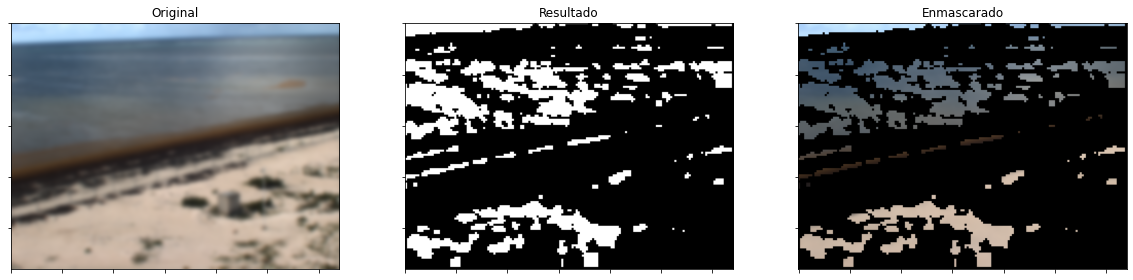

In [ ]:
prediccion(imagen,bayes)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 51840
PORCENTAGE DE SARGAZO: 4.22 %


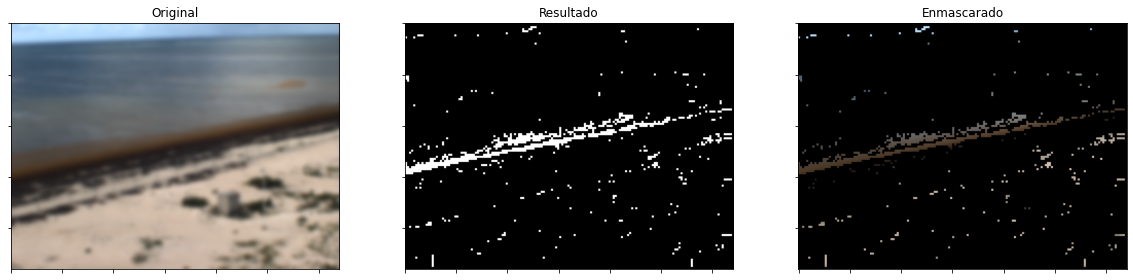

In [ ]:
prediccion(imagen,knn)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 37312
PORCENTAGE DE SARGAZO: 3.04 %


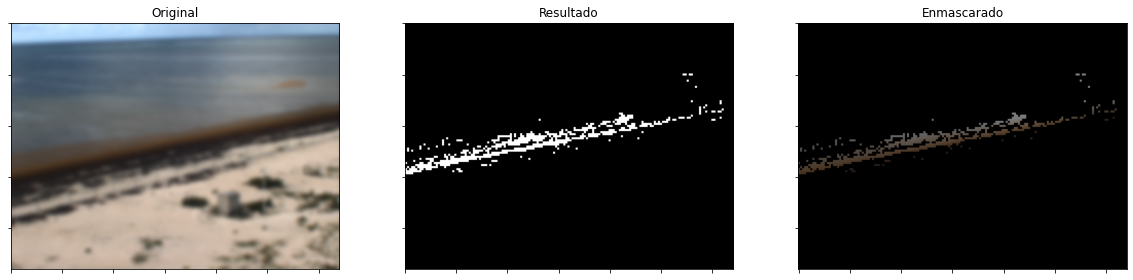

In [ ]:
prediccion(imagen,knn2)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 22976
PORCENTAGE DE SARGAZO: 1.87 %


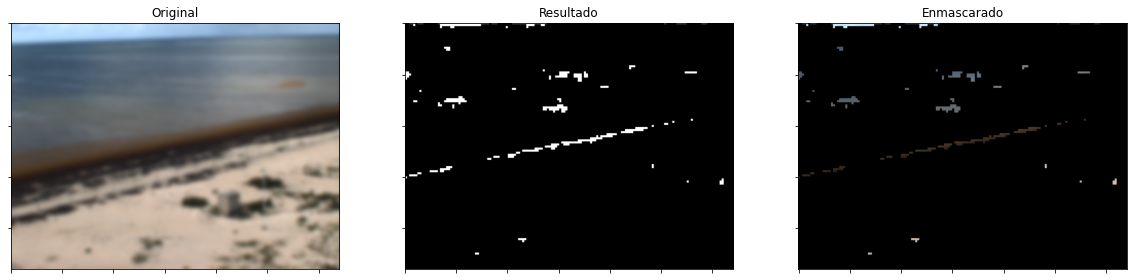

In [ ]:
prediccion(imagen,LR)

### Imagen 2

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 296768
PORCENTAGE DE SARGAZO: 24.15 %


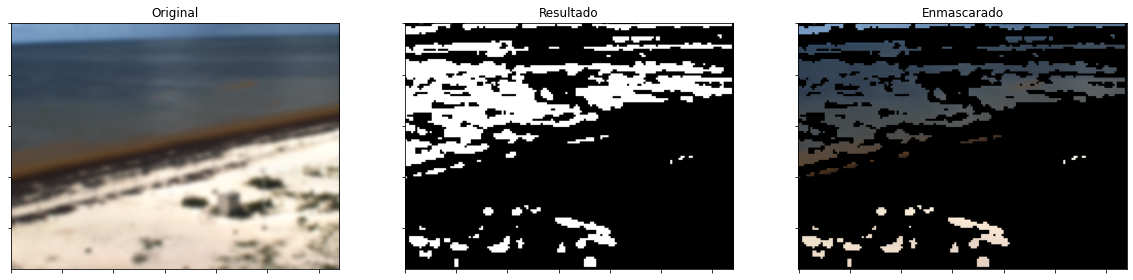

In [ ]:
prediccion(imagen2,bayes)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 86848
PORCENTAGE DE SARGAZO: 7.07 %


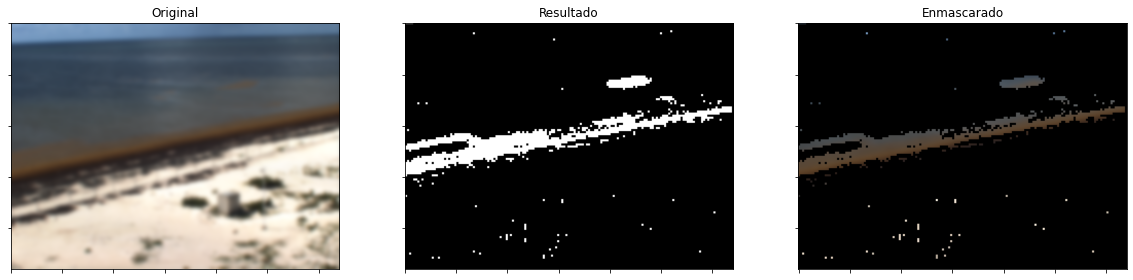

In [ ]:
prediccion(imagen2,knn)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 81088
PORCENTAGE DE SARGAZO: 6.6 %


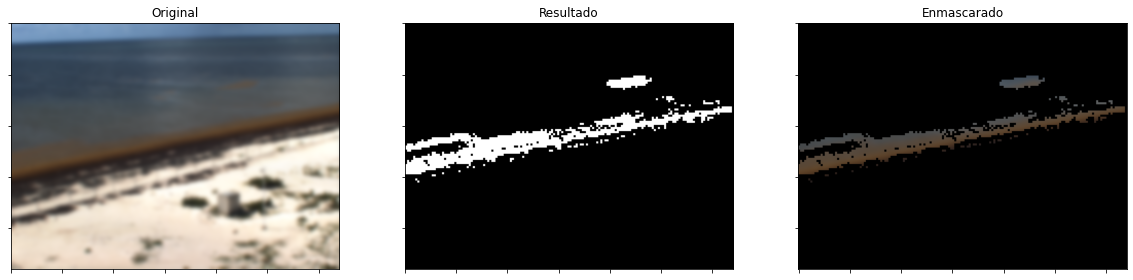

In [ ]:
prediccion(imagen2,knn2)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 49664
PORCENTAGE DE SARGAZO: 4.04 %


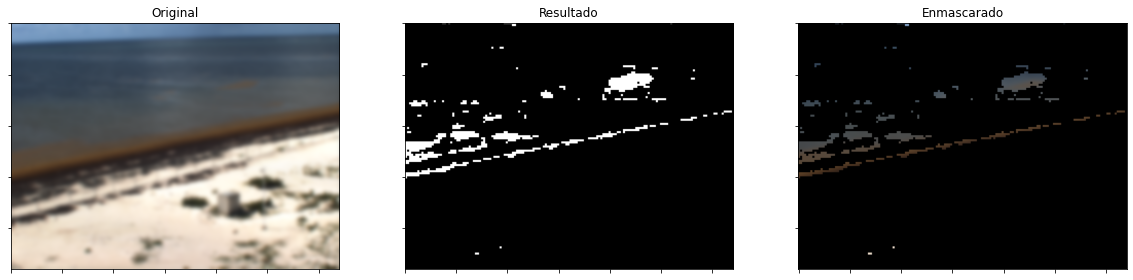

In [ ]:
prediccion(imagen2,LR)

### Imagen de prueba

In [ ]:
imagen_prueba = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/prueba1.png")
imagen_prueba = cv2.cvtColor( aplicar_blur(imagen_prueba, bg_x, bg_y, bg_s) , cv2.COLOR_BGR2RGB)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 105472
PORCENTAGE DE SARGAZO: 8.58 %


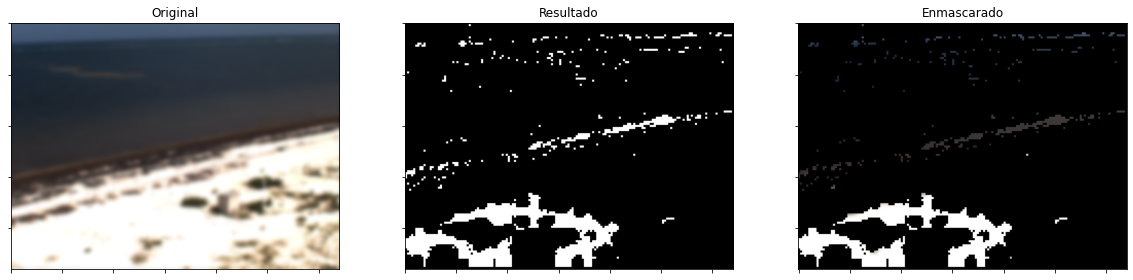

In [ ]:
prediccion(imagen_prueba, knn)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 99072
PORCENTAGE DE SARGAZO: 8.06 %


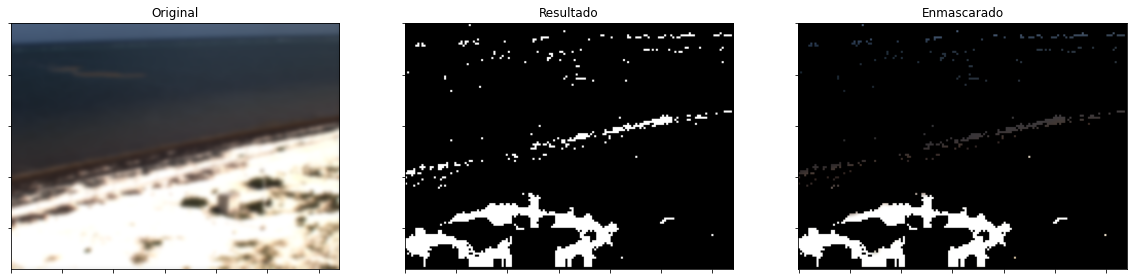

In [ ]:
prediccion(imagen_prueba, knn2)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 115328
PORCENTAGE DE SARGAZO: 9.39 %


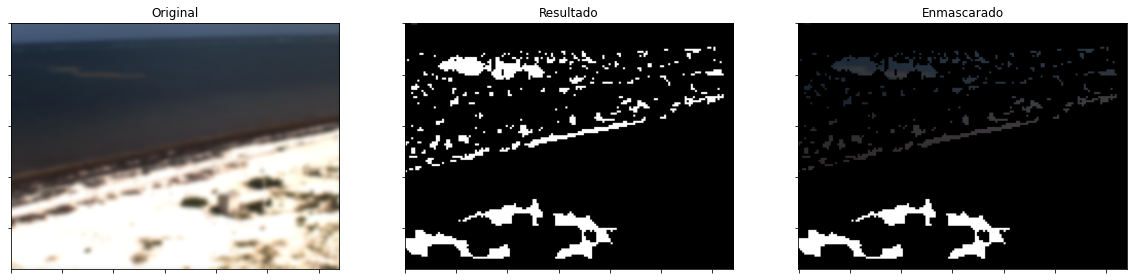

In [ ]:
prediccion(imagen_prueba, LR)

## Validación

In [ ]:
def validar(modelo, X, Y):
  cv_NB = cross_val_score(modelo, X, Y, cv = 4)
  print("Media de los 4 resultados:", round(np.mean(cv_NB)*100,2),"%" )
  print("Score:",round(modelo.score(X,Y)*100,2),"%")

In [ ]:
validar(bayes, X, Y)

Media de los 4 resultados: 68.35 %
Score: 68.91 %


In [ ]:
validar(knn, X, Y)

Media de los 4 resultados: 91.85 %
Score: 95.03 %


In [ ]:
validar(knn2, X, Y)

Media de los 4 resultados: 91.37 %
Score: 95.88 %


In [ ]:
validar(LR, X, Y)

Media de los 4 resultados: 85.19 %
Score: 85.12 %
